In [1]:
#importing general libraries needed to work with the data.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from scipy.stats import chi2_contingency
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

In [2]:
#importing natural language processing libraries to work with different word
import random 
import re
import pickle
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import digits, punctuation
from wordcloud import WordCloud, STOPWORDS

In [3]:
#Importing Machine Learning Libraries which will be needed to work on this data
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Cleaning Data 

In [4]:
data = pd.read_csv("data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})

In [5]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null object
Country        541909 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


#### Analysis on missing data

Text(0.5, 1.0, 'Ratio of missing values per columns')

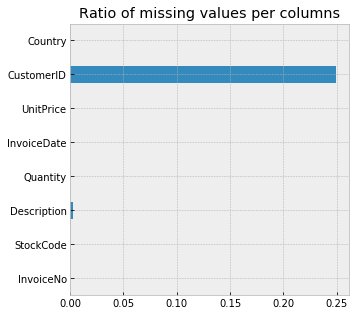

In [7]:
plt.figure(figsize=(5, 5))
data.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

#### Null values in detail

In [8]:
nan_rows = data[data.isnull().T.any().T]
nan_rows.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


<h4>
Since the missing values are only in the CustomerID column and the description column, we could try to look at the InvoiceNo and see if maybe we can find the Customer ID
 </h4>

In [9]:
data[data['InvoiceNo']== '536544'][:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,12/1/2010 14:32,1.66,NaN,United Kingdom


<h4>
It appears that we can't replace the missing values and we can't keep data without the value in the customer id columns since we want to classify the customers. So I'll drop the lines with missing values on the customer ID column.
</h4>

In [10]:
data = data.dropna(subset=["CustomerID"])

#### Checking if there are still any null values 

Text(0.5, 1.0, 'Ratio of missing values per columns')

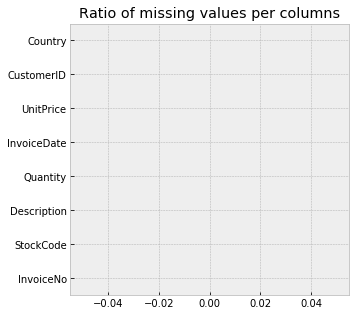

In [11]:
plt.figure(figsize=(5, 5))
data.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

#### Checking Dupicate entries in the data 

In [12]:
print('Dupplicate entries: {}'.format(data.duplicated().sum()))
data.drop_duplicates(inplace = True)

Dupplicate entries: 5225


## Exploratory Data Analysis 

#### 1) Countries

In [13]:
data.Country.nunique()

37

In [14]:
customer_country=data[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


##### More than 90% of the data is coming from UK !

#### 2) Quantity

In [15]:
data.describe()

,Quantity,UnitPrice
count,401604.000000,401604.000000
mean,12.183273,3.474064
std,250.283037,69.764035
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


In [16]:
data[(data['Quantity']<0)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom


 <ul>
  <li>The stock code values aren't only numerical, there are speciales values like D which means Discount </li>
  <li>The InvoiceNo aren't also only numerical since there is a C before the other numbers for every negative value in the quantity column, this could mean that the order was canceled.</li>

</ul> 

#### 3) InvoiceNo - Cancellation

In [17]:
# Constucting a basket for later use
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})

In [18]:
nb_products_per_basket.InvoiceNo = nb_products_per_basket.InvoiceNo.astype(str)
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
len(nb_products_per_basket[nb_products_per_basket['order_canceled']==1])/len(nb_products_per_basket)*100

16.466876971608833

<h5>It appears that more than 16% of the transactions were canceled which is significant. Let's take a look at some rows where the transaction was canceled.</h5>

In [19]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1][:5]

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


In [20]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346,United Kingdom


<h5>
By looking at these results, it appears that there is a counterpart to the canceled transaction in the database. Let's see if this is always the case.
</h5>

In [21]:
test = data[data['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  test.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(test.loc[index])
        print('Our initial hypothesis is wrong')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
Our initial hypothesis is wrong


In [22]:
data[data['CustomerID'] == '14527'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,12/5/2010 13:17,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/5/2010 13:17,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,12/5/2010 13:17,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,12/5/2010 13:17,3.95,14527,United Kingdom


<h5>
It appears that when there is a discount there are no counterparts. Let's try again but without the discount values
</h5>

In [23]:
data_check = data[(data['Quantity'] < 0) & (data['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  data_check.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(index, data_check.loc[index])
        print('The second hypothesis is also wrong')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
The second hypothesis is also wrong


In [24]:
data[(data['CustomerID'] == '15311') & (data['Description'] == 'SET OF 3 COLOURED  FLYING DUCKS')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,12/5/2010 13:55,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/8/2010 13:18,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,12/13/2010 15:07,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,12/20/2010 15:27,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,1/5/2011 11:41,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,1/17/2011 13:39,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2/1/2011 12:14,4.65,15311,United Kingdom


#### It seems that the customer can also cancel just a part of the transaction which is logical so we need to take this into account for later. 

In [25]:
df_cleaned = data.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  data.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = data[(data['CustomerID'] == col['CustomerID']) &
                         (data['StockCode']  == col['StockCode']) & 
                         (data['InvoiceDate'] < col['InvoiceDate']) & 
                         (data['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break    

In [26]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 6151
doubtfull_entry: 2607


In [27]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 37


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
27329,C538530,22630,DOLLY GIRL LUNCH BOX,-33,12/13/2010 10:26,1.95,14796,United Kingdom,0
32870,C539195,22942,CHRISTMAS LIGHTS 10 SANTAS,-5,12/16/2010 12:05,8.50,12748,United Kingdom,0
33085,C539221,22941,CHRISTMAS LIGHTS 10 REINDEER,-12,12/16/2010 12:56,8.50,14911,EIRE,0
33086,C539221,22942,CHRISTMAS LIGHTS 10 SANTAS,-10,12/16/2010 12:56,8.50,14911,EIRE,0
77599,C542744,22700,BLACK AND WHITE DOG BOWL,-10,1/31/2011 16:32,0.85,16191,United Kingdom,0


In [28]:
df_cleaned.drop(remaining_entries.index, axis = 0, inplace = True)

#### 4) Stockcode 

In [29]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

##### These are specific operations which doesn't characterize our customers so I'll just drop these transactions from our database 

In [30]:
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'POST']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'D']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'C2']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'M']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'BANK CHARGES']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'PADS']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'DOT']

#### 5) Outliers

In [31]:
df_cleaned.describe()

,Quantity,UnitPrice,QuantityCanceled
count,391183.000000,391183.000000,391183.000000
mean,13.179665,2.874130,0.583911
std,181.907403,4.284639,175.868790
min,1.000000,0.000000,0.000000
25%,2.000000,1.250000,0.000000
50%,6.000000,1.950000,0.000000
75%,12.000000,3.750000,0.000000
max,80995.000000,649.500000,80995.000000


##### The minimum value for the unitprice is 0, let's see why is that.

In [32]:
df_cleaned[(df_cleaned['UnitPrice'] == 0)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/5/2010 14:02,0.0,12647,Germany,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,12/16/2010 14:36,0.0,16560,United Kingdom,0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,12/21/2010 13:45,0.0,14911,EIRE,0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,1/6/2011 16:41,0.0,13081,United Kingdom,0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,1/6/2011 16:41,0.0,13081,United Kingdom,0


<h5>I am tempted to replace the null values by the most common one but it might be a special discount or something else so I'll leave it like that. Here let's remove the items that got completely canceled in order to harmonize the futur clusters and not have too much special values.</h5>